In [ ]:
import os
! pip install scipy --upgrade
os.kill(os.getpid(), 9)


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc
from mpl_toolkits.mplot3d import Axes3D as ax
import seaborn as sns

2024-01-05 10:08:23.328970: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 10:08:23.474122: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 10:08:23.474144: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 10:08:23.475123: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 10:08:23.552239: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 10:08:23.553287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
tf.keras.backend.set_floatx("float64")

In [3]:
def integrate(arr, h):
    N = len(arr)
    
    sum_odd = sum(arr[1::2])
    sum_even = sum(arr[2:-1:2])
    
    result = (h / 3) * (arr[0] + arr[-1] + 4 * sum_odd + 2 * sum_even)
    
    return result

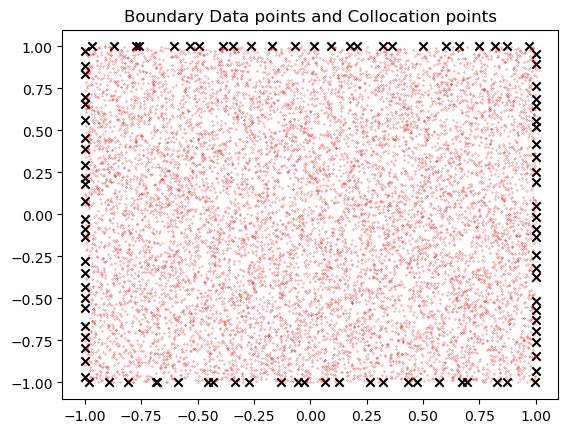

In [4]:
n_bc = 4
n_data_per_bc = 25

engine = qmc.LatinHypercube(d=1)
data = np.zeros([4, 25, 3])

for i, j in zip(range(n_bc), [-1, +1, -1, +1]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.5) * 2
    if i < 2:
        data[i, :, 0] = j
        data[i, :, 1] = points
    else:
        data[i, :, 0] = points
        data[i, :, 1] = j

data[0, :, 2] = 1. #actual degree 100
data[2, :, 2] = 3. #actual degree 300

data = data.reshape(n_data_per_bc * n_bc, 3) #With this process, the data data is obtained as a block.


x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1),[data[:, 0], data[:, 1], data[:, 2]])

#Creating random data in the boundry with latinhypercube
Nc = 10000
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 2 * (colloc -0.5) #This process expands the data produced in the range [0,1] to the range [-1,1].

x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="r", label="CP")
plt.show()

x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),[x_c, y_c, x_d, y_d, t_d])


In [5]:
#model building

def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=10,neuron_per_layer=20, actfn="tanh"):
    input_layer=tf.keras.layers.Input(shape=(in_shape,))  #The comma is necessary to 
    #create a tuple, if we write it without a comma, in_shape will be perceived as just 
    #a number and the size of the input data cannot be adjusted as desired.
    
    hidden_layer=[tf.keras.layers.Dense(neuron_per_layer,activation=actfn)(input_layer)]
    
    for i in range(n_hidden_layers-1):
        new_layer=tf.keras.layers.Dense(neuron_per_layer,activation=actfn,activity_regularizer=None)(hidden_layer[-1])
        hidden_layer.append(new_layer)
    
    output_layer=tf.keras.layers.Dense(1,activation=None)(hidden_layer[-1])
    name=f"DNN-{n_hidden_layers}"
    model=tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [6]:
tf.keras.backend.clear_session()
model=DNN_builder()
model.summary()

Model: "DNN-10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420  

In [7]:
#Functions

@tf.function
def u(x,y):
    u=model(tf.concat([x,y],axis=1))
    return u

@tf.function
def f(x,y): # alpha (the thermal diffusivity) assumed -1
    u0=u(x,y)
    ux=tf.gradients(u0,x)[0] #The meaning of zero is to take the first of 
    #the outputs of the gradients function, that is, the derivative.
    uy=tf.gradients(u0,y)[0]
    uxx=tf.gradients(ux,x)[0]
    uyy=tf.gradients(uy,y)[0]
    F=uxx+uyy
    return tf.reduce_mean(tf.square(F))

@tf.function
def MSE(y,y_): #mean squared error
    return tf.reduce_mean(tf.square(y-y_))

    0,2.214
  100,0.570
  200,0.429
  300,0.274
  400,0.199
  500,0.173
  600,0.164
  700,0.159
  800,0.157
  900,0.155
 1000,0.152
It takes  7.88069517215093  minutes


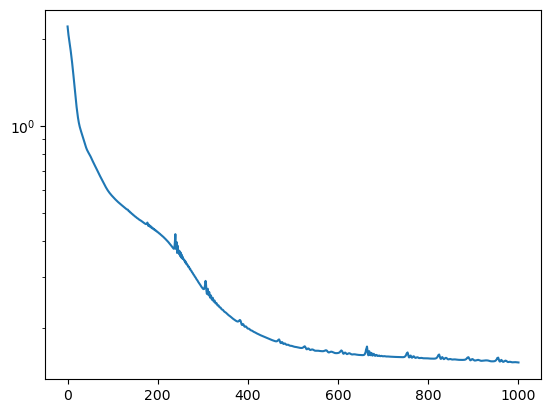

In [8]:
#Loss function

loss=0
epoch=1001
optimizer= tf.keras.optimizers.Adam(learning_rate=5e-4)

loss_val=np.array([])

start = time.time()
for i in range(epoch):
    with tf.GradientTape() as tape:
        T=u(x_d,y_d)  # Temperature data created from boundary
        L=f(x_c,y_c)  # Losses from created x-y points
        l=MSE(t_d,T) 
        
        loss=L+l
        
    g=tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(g, model.trainable_weights))
    loss_val=np.append(loss_val,loss)
    if i % 100 ==0:
        print(f"{i:5},{loss.numpy():.3f}")
        
end = time.time()
plt.semilogy(loss_val, label=model.name)

print("It takes ",(end-start)/60," minutes")


In [9]:
### plotting
n=100
plt.figure("", figsize=(12, 6))

X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)

<Figure size 1200x600 with 0 Axes>

3.1027681359886603e-07


/tmp/ipykernel_49347/3516631873.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout( pad=2.5)


(-1.0101010101010102,
 1.0101010101010097,
 -1.0101010101010102,
 1.0101010101010097)

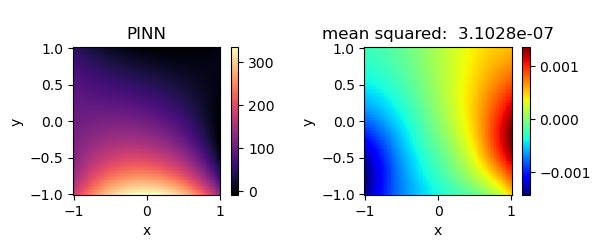

In [29]:
plt.subplot(221)
plt.pcolormesh(X0, Y0, 100.*S, cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN")
plt.tight_layout()
plt.axis("square")

plt.subplot(222)
pinn_grad = np.gradient(np.gradient(S, axis=0), axis=1)
sigma_pinn = (pinn_grad**2).mean()
print(sigma_pinn)
plt.pcolormesh(X0, Y0, pinn_grad, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"\nmean squared: {sigma_pinn: .4e}")
plt.tight_layout( pad=2.5)
plt.axis("square")